In [ ]:
import pandas as pd
from scipy import stats

from datasets import load_3did_DDIs
from matplotlib import pyplot as plt

from plotting import validation_plot, COLOR_ALPHAFOLD_ROSETTAFOLD

In [2]:
def load_I3D_exp_24(organism):
    i3d = pd.read_csv(
        f"../data/external/interactome3d_2024-12_{organism}_interactions.dat", sep="\t"
    )
    i3d = i3d.loc[i3d["TYPE"] == "Structure", :]
    return i3d


zhang = pd.read_csv('../output/AFRF-core_human.tsv', sep='\t', index_col=0)
i3d = load_I3D_exp_24('h_sapiens')
i3d['uniprot_ac_a'] = i3d[['PROT1', 'PROT2']].min(axis=1)
i3d['uniprot_ac_b'] = i3d[['PROT1', 'PROT2']].max(axis=1)
i3d['pair'] = i3d['uniprot_ac_a'] + '_' + i3d['uniprot_ac_b']
i3d = i3d.set_index('pair')

dmi = pd.read_csv('../data/external/elm_interactions_2024-01-30.tsv', sep='\t')
dmi = dmi.loc[(dmi['taxonomyElm'] == "9606(Homo sapiens)")
              & (dmi['taxonomyDomain'] == "9606(Homo sapiens)"), :]
dmi['uniprot_ac_a'] = dmi[['interactorElm', 'interactorDomain']].min(axis=1)
dmi['uniprot_ac_b'] = dmi[['interactorElm', 'interactorDomain']].max(axis=1)
dmi['pair'] = dmi['uniprot_ac_a'] + '_' + dmi['uniprot_ac_b']
dmi = dmi.loc[(dmi['uniprot_ac_a'] != dmi['uniprot_ac_b']), :]
dmi = dmi.loc[dmi['pair'].isin(i3d.index), :]
dmi = dmi.drop_duplicates('pair')

ddi = load_3did_DDIs()
i3d['pdb_chains_ids'] = i3d['PDB_ID'] + '_' + i3d[['CHAIN1', 'CHAIN2']].min(axis=1) + '_' + i3d[['CHAIN1', 'CHAIN2']].max(axis=1)
ddi['pdb_chains_ids'] = ddi['pdb_id'] + '_' + ddi[['chain_1', 'chain_2']].min(axis=1) + '_' + ddi[['chain_1', 'chain_2']].max(axis=1)
ddi = pd.merge(i3d.reset_index(), ddi, how='inner', on='pdb_chains_ids')
# remove small number that map to both DDI and DMI
ddi = ddi.loc[~ddi['pair'].isin(dmi['pair']), :]
ddi = ddi.drop_duplicates('pair')

SignificanceResult(statistic=1.980775038436196, pvalue=0.00019591945238760775)


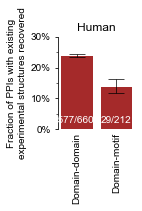

In [3]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.4, h=1.7)
pos = [ddi['pair'].isin(zhang.index).sum(),
       dmi['pair'].isin(zhang.index).sum()]
ns = [ddi.shape[0], dmi.shape[0]]
print(stats.fisher_exact([pos, [ns[0] - pos[0], ns[1] - pos[1]]], alternative='greater'))
validation_plot(positives=pos,
                n_tested=ns,
                labels=['Domain-domain', 'Domain-motif'],
                colors=[COLOR_ALPHAFOLD_ROSETTAFOLD, COLOR_ALPHAFOLD_ROSETTAFOLD],
                y_max=0.3,
                ax=ax,
                errorbar_capsize=0.5,
                errorbar_thickness=0.7,
                )
ax.set_ylabel('Fraction of PPIs with existing\nexperimental structures recovered')
ax.set_title('Human')
ax.xaxis.set_tick_params(rotation=90, length=0)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('white')
ax.set_yticklabels(['{:.0f}%'.format(y * 100) for y in ax.get_yticks()])
fig.savefig('../figures/zhang_recovery-of-PDB_split-by-DDI-vs-DMI_bar.pdf', bbox_inches='tight')